In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from utils import convert_less_than, plot_distribution
from plots import plot_PCA

In [2]:
COLUMNS = ["Carbon concentration / (weight%)", 
           "Silicon concentration / (weight%)", 
           "Manganese concentration / (weight%)", 
           "Sulphur concentration / (weight%)", 
           "Phosphorus concentration / (weight%)", 
           "Nickel concentration / (weight%)", 
           "Chromium concentration / (weight%)", 
           "Molybdenum concentration / (weight%)", 
           "Vanadium concentration / (weight%)", 
           "Copper concentration / (weight%)", 
           "Cobalt concentration / (weight%)", 
           "Tungsten concentration / (weight%)", 
           "Oxygen concentration / parts per million by weight", 
           "Titanium concentration / parts per million by weight", 
           "Nitrogen concentration / parts per million by weight", 
           "Aluminium concentration / parts per million by weight", 
           "Boron concentration / parts per million by weight", 
           "Niobium concentration / parts per million by weight", 
           "Tin concentration / parts per million by weight", 
           "Arsenic concentration / parts per million by weight", 
           "Antimony concentration / parts per million by weight", 
           "Current / A", 
           "Voltage / V", 
           "AC or DC", 
           "Electrode positive or negative", 
           "Heat input / kJmm-1", 
           "Interpass temperature / °C", 
           "Type of weld", 
           "Post weld heat treatment temperature / °C", 
           "Post weld heat treatment time / hours", 
           "Yield strength / MPa", 
           "Ultimate tensile strength / MPa", 
           "Elongation / %", 
           "Reduction of Area / %", 
           "Charpy temperature / °C", 
           "Charpy impact toughness / J", 
           "Hardness / kgmm-2", 
           "50% FATT", 
           "Primary ferrite in microstructure / %", 
           "Ferrite with second phase / %", 
           "Acicular ferrite / %", 
           "Martensite / %", 
           "Ferrite with carbide aggreagate / %",
            "Weld ID"
            ]
CATEGORICAL_COL = [
    "AC or DC", 
    "Electrode positive or negative", 
    "Type of weld", 
    "Weld ID"
]
MECHANICAL_PROPERTIES = [
    "Yield strength / MPa",
    "Ultimate tensile strength / MPa",
    "Elongation / %",
    "Reduction of Area / %",
    "Charpy temperature / °C",
    "Charpy impact toughness / J",
    "Hardness / kgmm-2",
    "50% FATT",
    "Primary ferrite in microstructure / %",
    "Ferrite with second phase / %",
    "Acicular ferrite / %",
    "Martensite / %",
    "Ferrite with carbide aggreagate / %"
]
NUMERICAL_COL = list(set(COLUMNS) - set(CATEGORICAL_COL))

In [3]:
def create_database(file_path):

    db = pd.read_csv(file_path, delimiter = "\s+", names=COLUMNS, na_values='N').drop('Weld ID', axis=1)
    db[NUMERICAL_COL] = db[NUMERICAL_COL].apply(convert_less_than)
    db[NUMERICAL_COL] = db[NUMERICAL_COL].apply(pd.to_numeric, errors='coerce')

    db.to_csv("table.csv", index=False)
    return db

In [4]:
file_path="welddb/welddb.data"
db = create_database(file_path)

### - Handling outliers

KEEP IN MIND:

If you impute missing values first, the imputation might be influenced by outliers, leading to biased values. By removing or adjusting outliers first, you can achieve a more representative imputation.


Some algorithms (like linear regression) are sensitive to outliers, which can heavily influence the results. Handling outliers first might lead to a more stable model if the algorithm you choose is susceptible to them.

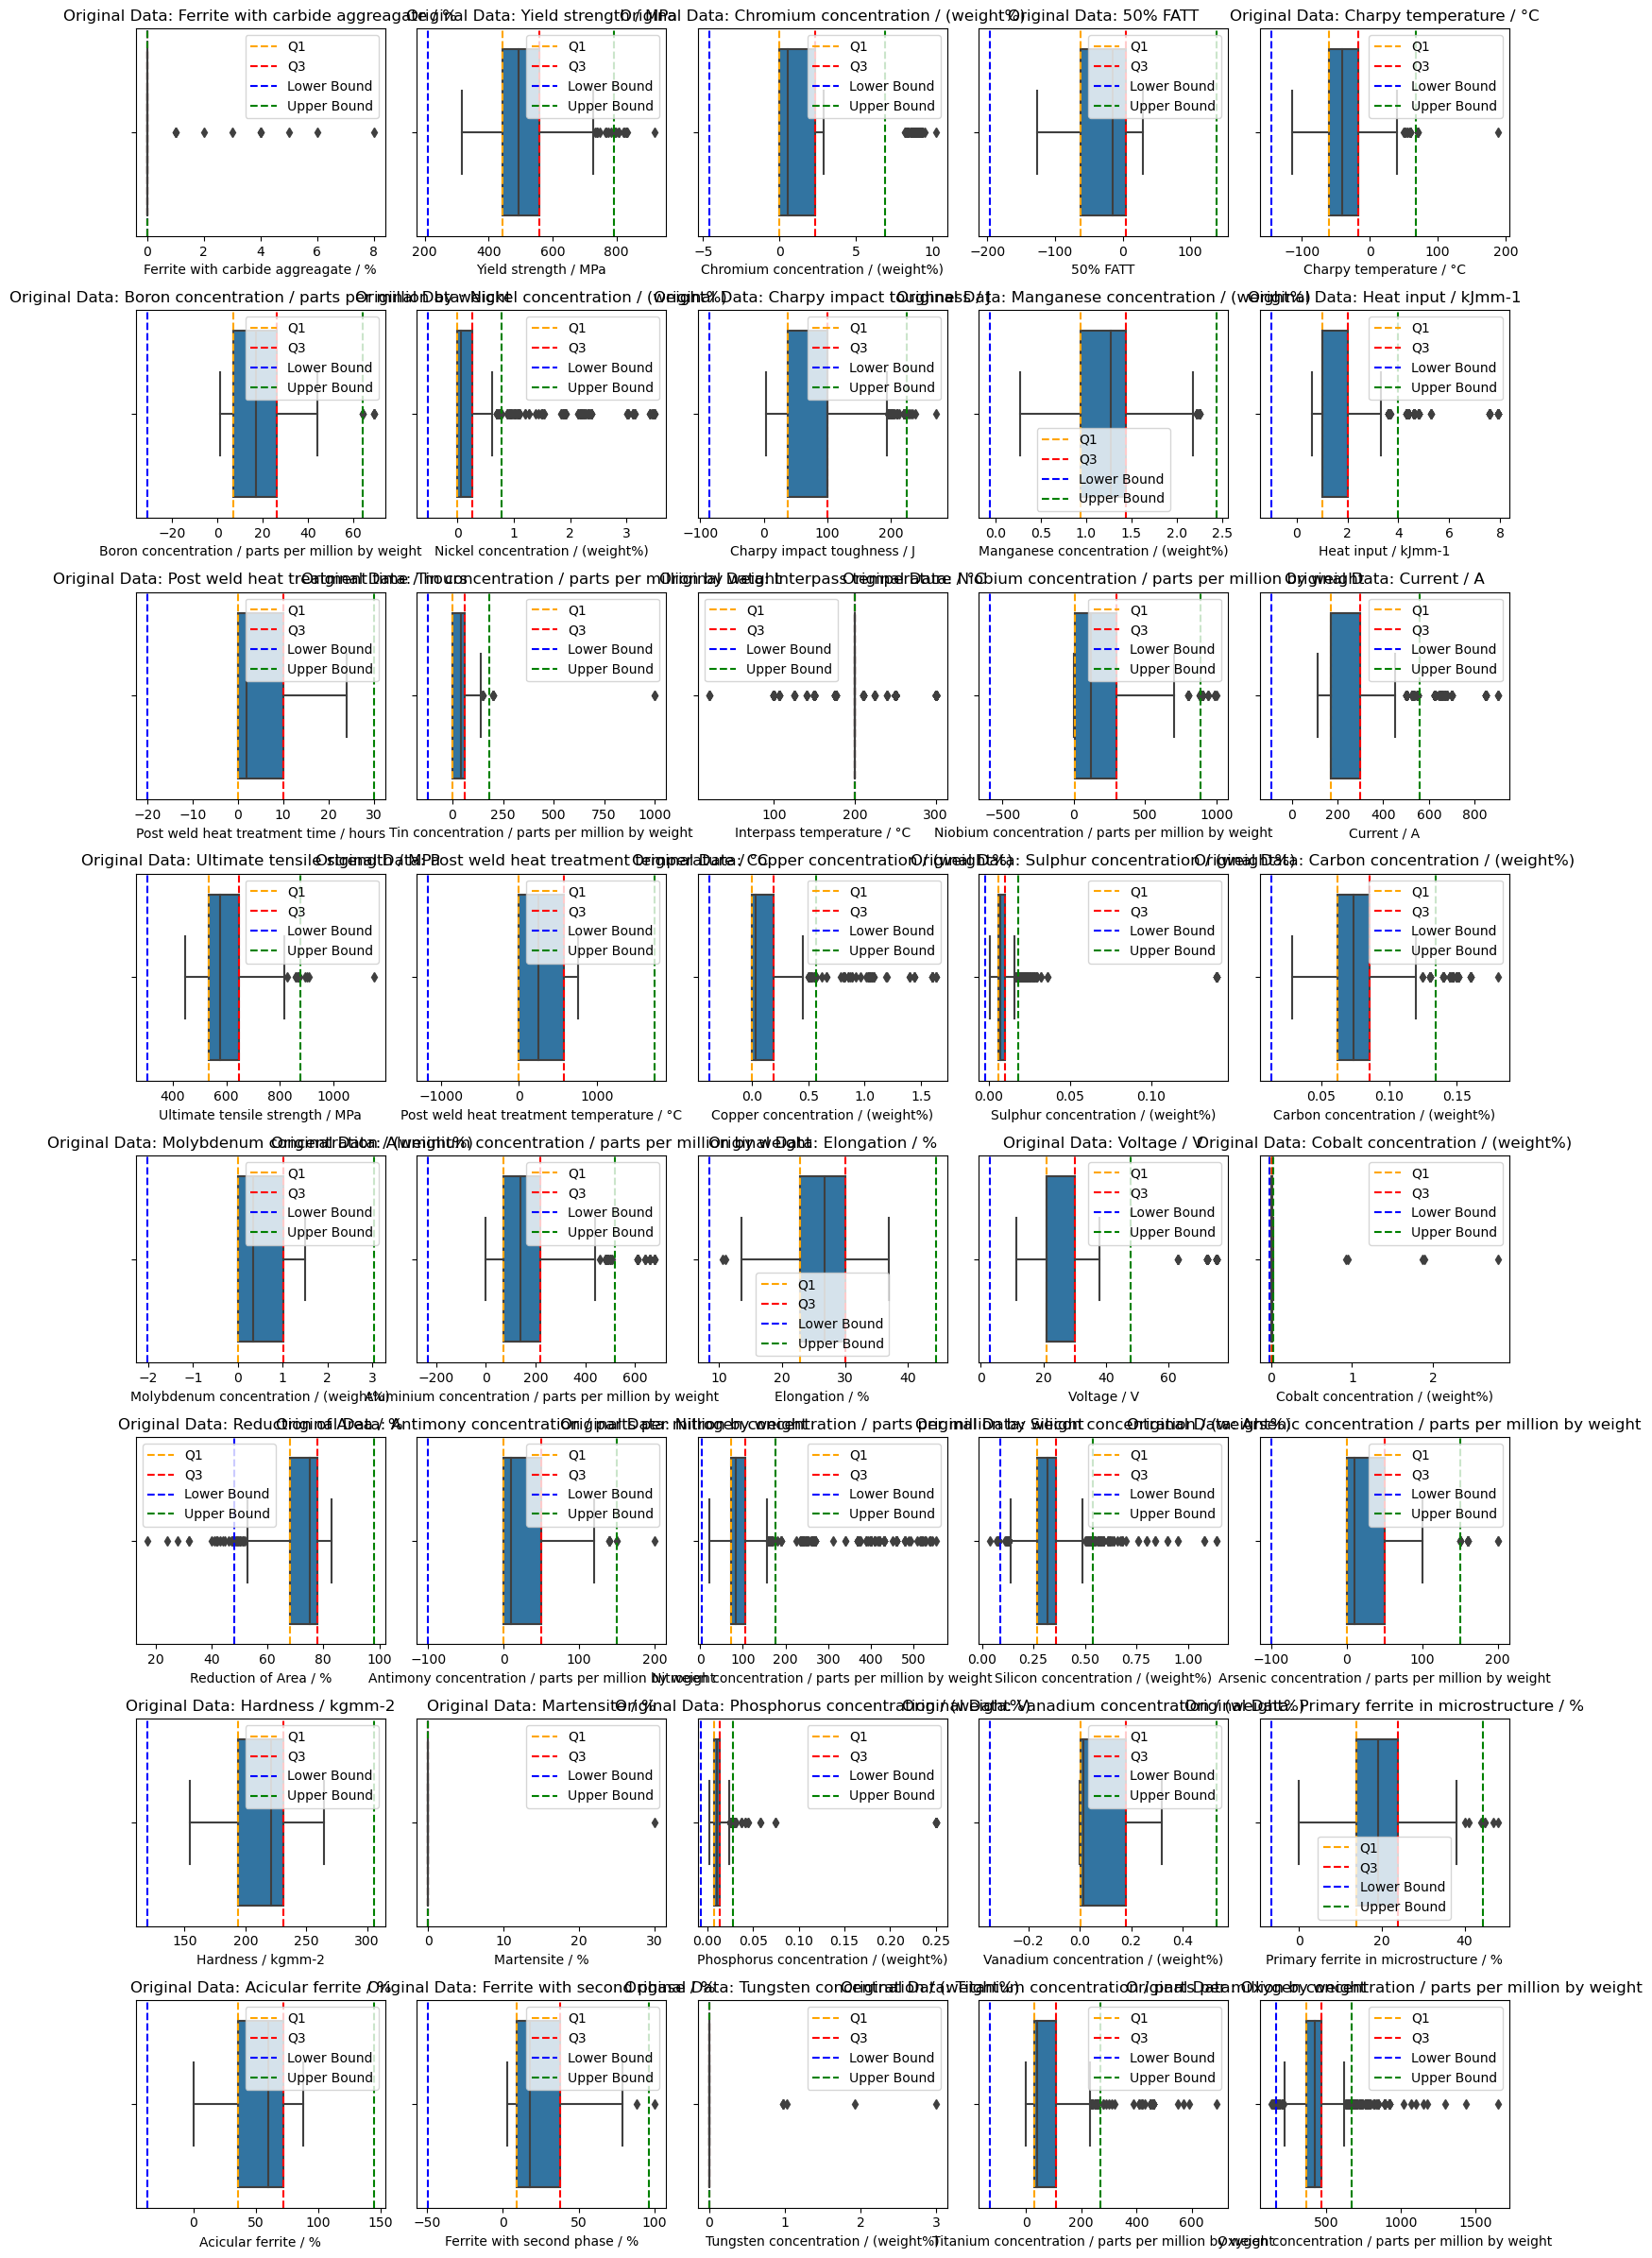

In [5]:
# Set up the figure for plotting
num_features = len(NUMERICAL_COL)
n_cols = 5  
n_rows = (num_features + n_cols - 1) // n_cols 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
axes = axes.flatten()

def plot_distribution_with_quartiles(original_data, feature, ax):
    # Calculate quartiles and IQR for original data
    Q1 = original_data[feature].quantile(0.25)
    Q3 = original_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 2 * IQR
    upper_bound = Q3 + 2 * IQR
    
    # Boxplot for original data
    sns.boxplot(x=original_data[feature], ax=ax)
    ax.axvline(Q1, color='orange', linestyle='--', label='Q1')
    ax.axvline(Q3, color='red', linestyle='--', label='Q3')
    ax.axvline(lower_bound, color='blue', linestyle='--', label='Lower Bound')
    ax.axvline(upper_bound, color='green', linestyle='--', label='Upper Bound')
    ax.set_title(f'Original Data: {feature}')
    ax.legend()

# Plot distributions for each numerical feature
for i, col in enumerate(NUMERICAL_COL):
    plot_distribution_with_quartiles(db, col, axes[i])

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [6]:
# Strategy to deal with outliers ???

### - Handling categorical features
- Handling **'Type of weld'** feature

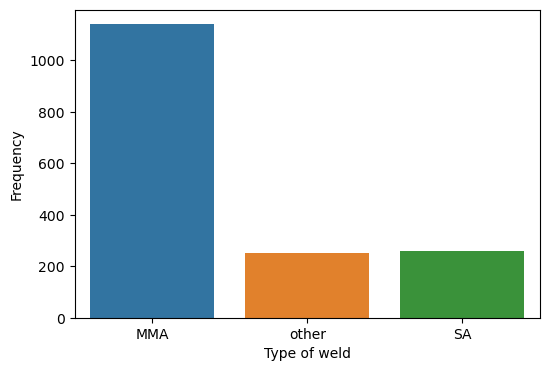

In [7]:
types_of_weld = ['MMA', 'SA', 'other']
db2 = db["Type of weld"]
db.loc[:, 'Type of weld'] = db['Type of weld'].apply(lambda x: x if x in types_of_weld else 'other')
plot_distribution(db['Type of weld'])

db = pd.get_dummies(db, columns=['Type of weld'], prefix='weld', dtype=int,).drop(columns=['weld_other'])

CATEGORICAL_COL.extend(['weld_MMA', 'weld_SA'])

- Handling **'AC or DC'** feature

In [8]:
cpt = 0

for i, row in db.iterrows():
    if pd.isna(row["AC or DC"]):
        
        if row['Electrode positive or negative'] == 0:
            cpt += 1
            db.loc[i, "AC or DC"] = "AC"  
        else:
            cpt += 1
            db.loc[i, "AC or DC"] = "DC"

print(f"Total imputed: {cpt}")

Total imputed: 215


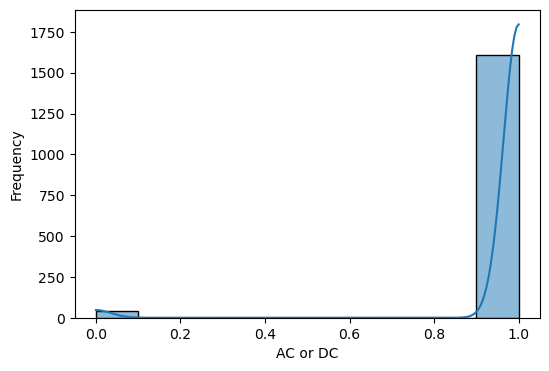

In [9]:
mapping_dict = {'AC': 0, 'DC': 1}
db['AC or DC'] = db['AC or DC'].map(mapping_dict)

plot_distribution(db['AC or DC'])

- Handling **'Electrode positive or negative'** feature

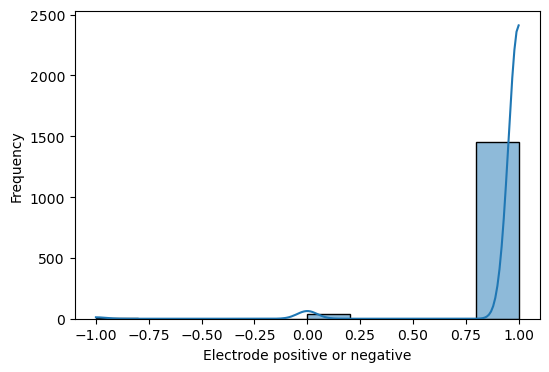

In [10]:
mapping_dict = {'+': 1, '0': 0, '-': -1}
db['Electrode positive or negative'] = db['Electrode positive or negative'].map(mapping_dict)
plot_distribution(db['Electrode positive or negative'])

### - Selecting relavant features based on Correlation and Completeness
#### TARGET = Yield strength / MPa

In [11]:
def get_corr(table:pd.DataFrame, threshold):
    # Initialize the result dictionary
    col_info = {
        'below_threshold': [],  # Columns with too many missing values
        'above_threshold': [],  # Columns passing the threshold
        'columns': {}           # Store correlation and missing percentage
    }
    
    for col in table.columns:
        column = table[col]
        missing_ratio = column.isnull().mean()
        
        col_info['columns'][col] = {'missing_ratio': missing_ratio}
        if missing_ratio > 1 - threshold:
            col_info['below_threshold'].append(col)
        else:
            col_info['above_threshold'].append(col)
        
        valid_rows = table[[col, 'Yield strength / MPa']].dropna()
        
        if not valid_rows.empty and col not in CATEGORICAL_COL:
            correlation = valid_rows.corr()
            col_info['columns'][col]['correlation_with_output'] = correlation.values[0,1]
        else:
            col_info['columns'][col]['correlation_with_output'] = np.nan  # No valid data to correlate

    return col_info

In [12]:
threshold = 0.3
col_info = get_corr(db, threshold)
# col_info

In [13]:
points = np.array([(0, 0.45), (0.6, 0.05)])
x_points = points[:, 0]
y_points = points[:, 1]
coefficients = np.polyfit(x_points, y_points, 2)
feature_decision = np.vectorize(lambda completeness: max(0.05, np.polyval(coefficients, completeness)))


def plot_completeness_vs_corr(col_info, feature_decision=feature_decision):
    # Initialize lists to store x (completeness) and y (correlation) values
    x_completeness = []
    y_correlation = []
    column_names = []

    if feature_decision is None:
        features = col_info
    else:
        features=[]

    # Loop through the columns in col_info
    for col, info in col_info['columns'].items():
        if 'correlation_with_output' in info:  # Only consider columns with calculated correlation
            if col=='output':
                continue

            completeness = 1 - info['missing_ratio'] 
            correlation = abs(info['correlation_with_output'])
            
            x_completeness.append(completeness)
            y_correlation.append(correlation)
            column_names.append(col)
            if feature_decision is not None and feature_decision(completeness) >= correlation:
                features.append(col)
    
    # Plotting
    plt.figure(figsize=(20, 20))
    plt.scatter(x_completeness, y_correlation, color='b', marker='o')
    plt.ylim(0, 0.5)
    
    # Label each point with the column name
    for i, txt in enumerate(column_names):
        plt.annotate(txt, (x_completeness[i], y_correlation[i]), fontsize=9, ha='right')

    if feature_decision is not None:
        comp = np.linspace(min(x_completeness), max(x_completeness), 100)
        corr = feature_decision(comp)
        plt.plot(comp, corr, '-r')

    # Labels and title (in French)
    plt.xlabel("Complétude de la colonne (%)", fontsize=12)
    plt.ylabel("Corrélation avec 'output' en valeur absolue", fontsize=12)
    plt.title("Complétude vs Corrélation avec 'output'= Yield strength / MPa", fontsize=14)

    # Show grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

    return features

c:\Users\natha\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


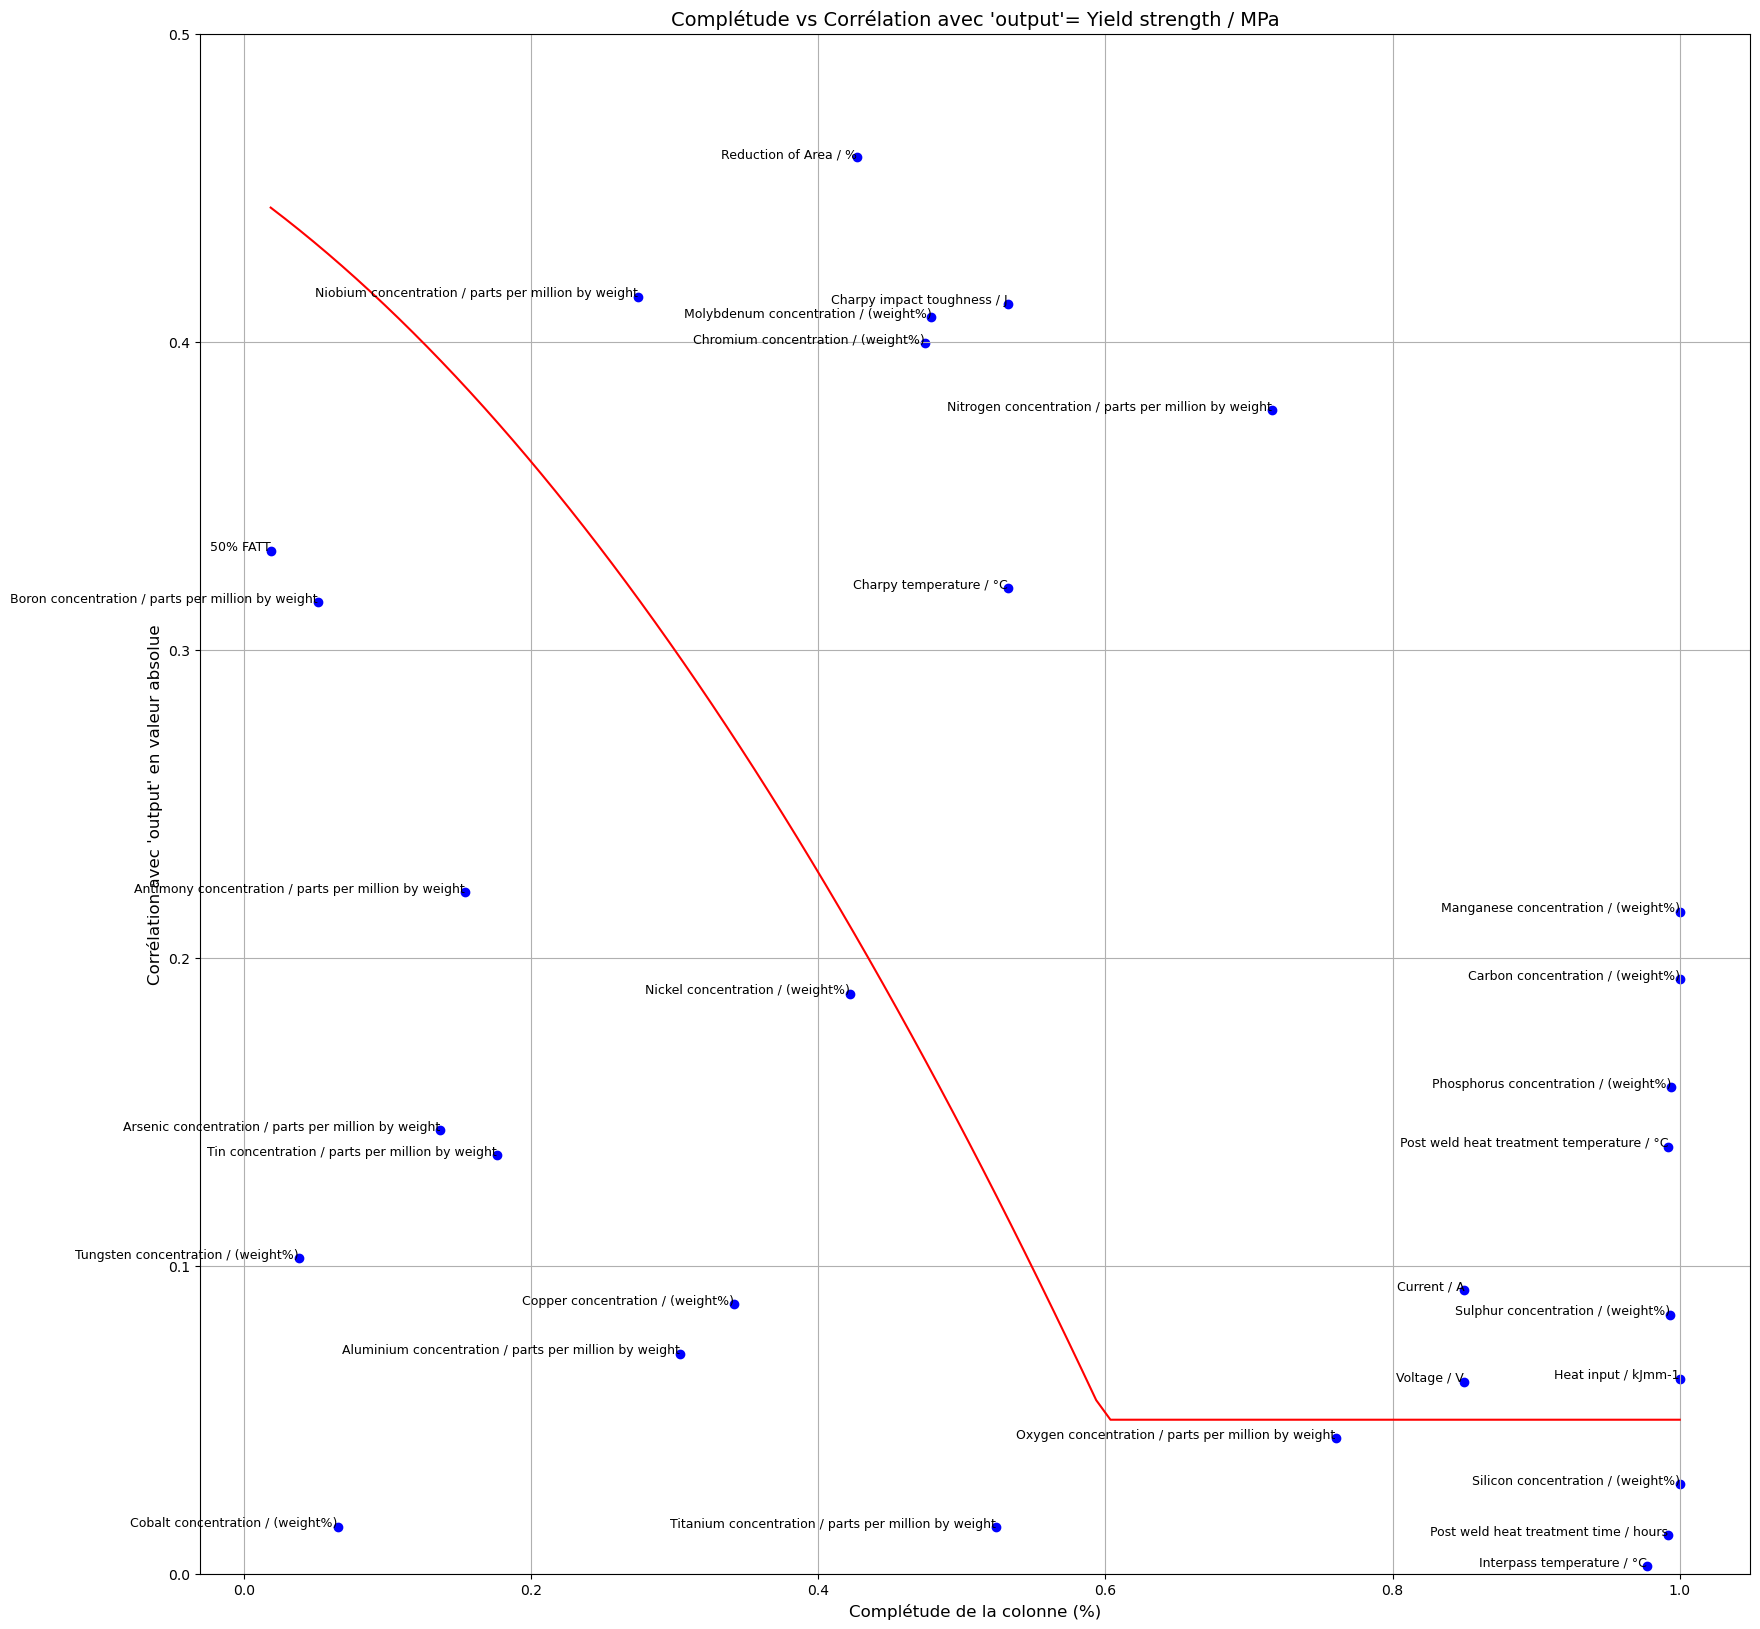

In [14]:
irrelevant_features = plot_completeness_vs_corr(col_info)

In [15]:
db.columns

Index(['Carbon concentration / (weight%)', 'Silicon concentration / (weight%)',
       'Manganese concentration / (weight%)',
       'Sulphur concentration / (weight%)',
       'Phosphorus concentration / (weight%)',
       'Nickel concentration / (weight%)',
       'Chromium concentration / (weight%)',
       'Molybdenum concentration / (weight%)',
       'Vanadium concentration / (weight%)',
       'Copper concentration / (weight%)', 'Cobalt concentration / (weight%)',
       'Tungsten concentration / (weight%)',
       'Oxygen concentration / parts per million by weight',
       'Titanium concentration / parts per million by weight',
       'Nitrogen concentration / parts per million by weight',
       'Aluminium concentration / parts per million by weight',
       'Boron concentration / parts per million by weight',
       'Niobium concentration / parts per million by weight',
       'Tin concentration / parts per million by weight',
       'Arsenic concentration / parts per millio

In [16]:
relevant_features = list(set(db.columns) - set(irrelevant_features) - set(MECHANICAL_PROPERTIES) | set(["Yield strength / MPa"]))
df = db[relevant_features]

In [17]:
df.isna().mean()

Carbon concentration / (weight%)                        0.000000
AC or DC                                                0.000000
Molybdenum concentration / (weight%)                    0.521186
Voltage / V                                             0.150121
weld_SA                                                 0.000000
Electrode positive or negative                          0.094431
Yield strength / MPa                                    0.527845
Chromium concentration / (weight%)                      0.525424
Nitrogen concentration / parts per million by weight    0.283898
weld_MMA                                                0.000000
Manganese concentration / (weight%)                     0.000000
Heat input / kJmm-1                                     0.000000
Phosphorus concentration / (weight%)                    0.006053
Niobium concentration / parts per million by weight     0.725787
Current / A                                             0.150121
Vanadium concentration / 

### - Handling missing values
- Numerical values

In [18]:
df1 = df.copy()

num_cols_to_impute = list(set(df1.columns) - set(CATEGORICAL_COL) - set(["Yield strength / MPa"]))
num_cols_to_impute

['Carbon concentration / (weight%)',
 'Manganese concentration / (weight%)',
 'Heat input / kJmm-1',
 'Phosphorus concentration / (weight%)',
 'Molybdenum concentration / (weight%)',
 'Niobium concentration / parts per million by weight',
 'Current / A',
 'Voltage / V',
 'Vanadium concentration / (weight%)',
 'Chromium concentration / (weight%)',
 'Post weld heat treatment temperature / °C',
 'Nitrogen concentration / parts per million by weight',
 'Sulphur concentration / (weight%)']

In [19]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

iterative_imputer = IterativeImputer(random_state=42, sample_posterior=True)

df1[num_cols_to_impute] = iterative_imputer.fit_transform(df1[num_cols_to_impute])

- Categorical values

In [20]:
non_missing_values = df['Electrode positive or negative'].dropna()

def random_imputation(series):

    missing = series.isnull()
    imputed_values = non_missing_values.sample(n=missing.sum(), replace=True, random_state=42).values
    series.loc[missing] = imputed_values

    return series

df1['Electrode positive or negative'] = random_imputation(df1['Electrode positive or negative'])

C:\Users\natha\AppData\Local\Temp\ipykernel_25900\2725299324.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series.loc[missing] = imputed_values


In [21]:
df1.to_csv("table_with_imputations.csv", index=False)

### Extracting dataset where TARGET != None

In [22]:
db["Yield strength / MPa"].isna().mean()

0.5278450363196125

We extract rows with "Yield strength / MPa" not None to create our dataset.

In [23]:
df = db.dropna(subset=['Yield strength / MPa'])
df.shape

(780, 44)

### PCA Analysis of the completion to find extra outliers

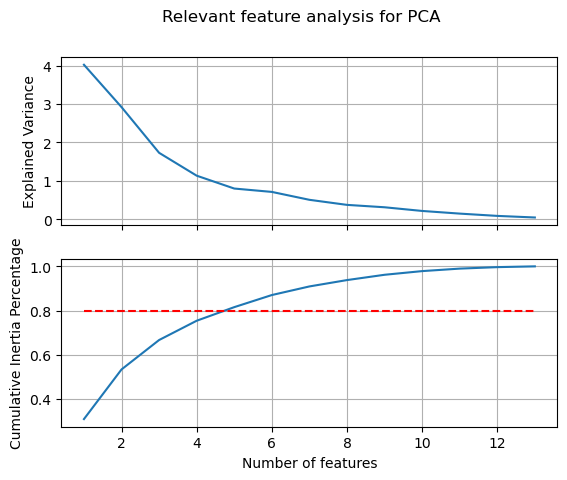

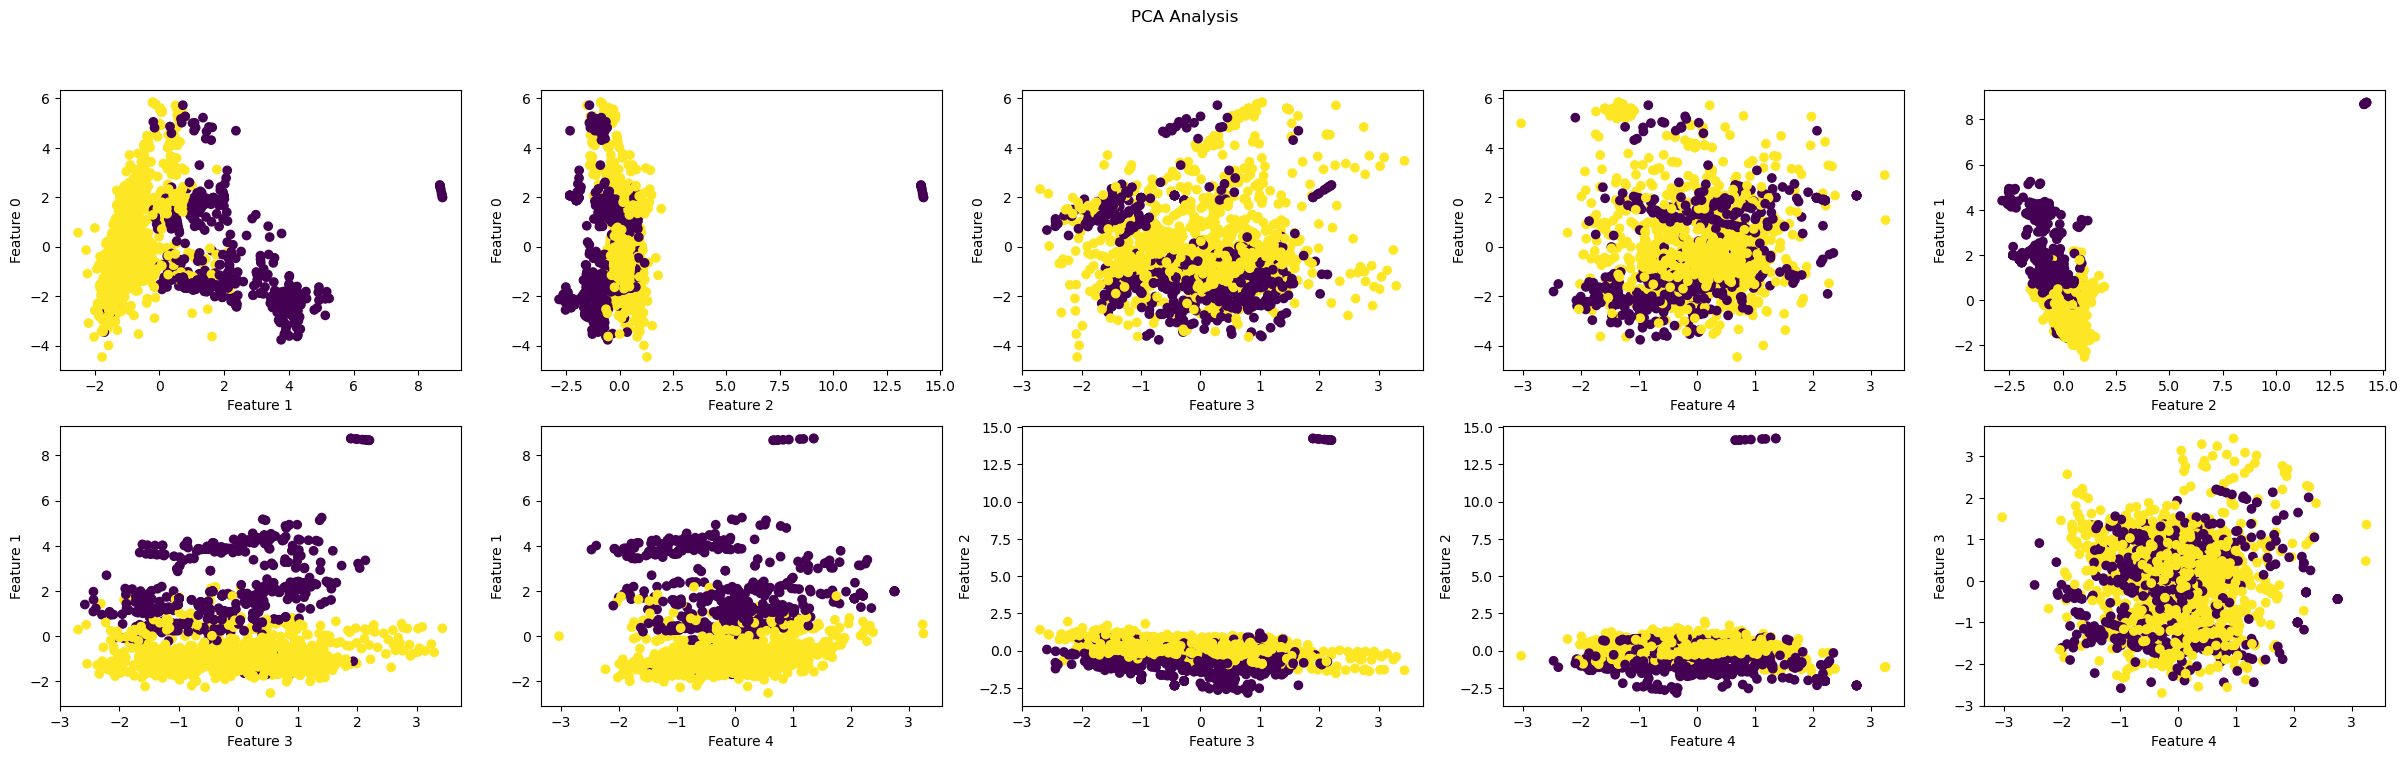

In [24]:
pca_features = list(set(relevant_features) - set(["Yield strength / MPa"]+ CATEGORICAL_COL))
pca, nb_relevant_features = plot_PCA(df1, pca_features, 'weld_MMA')

### Representation of welding features in the PCA components

In [25]:
vectors = pca.transform(np.eye(len(pca_features)))[:,:nb_relevant_features]
dict_representation = {pca_features[i] : np.linalg.norm(vectors[i]) for i in range(len(vectors))}
dict_representation

c:\Users\natha\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


{'Carbon concentration / (weight%)': 0.8054976679290559,
 'Manganese concentration / (weight%)': 0.7332031895660865,
 'Heat input / kJmm-1': 0.5876990127650306,
 'Phosphorus concentration / (weight%)': 0.7021102133533591,
 'Molybdenum concentration / (weight%)': 0.5226150861710744,
 'Niobium concentration / parts per million by weight': 0.6238414411907298,
 'Current / A': 0.5803692099082216,
 'Voltage / V': 0.5719752375233903,
 'Vanadium concentration / (weight%)': 0.5571998813117433,
 'Chromium concentration / (weight%)': 0.5097030403961234,
 'Post weld heat treatment temperature / °C': 0.5262411217872223,
 'Nitrogen concentration / parts per million by weight': 0.573030418652515,
 'Sulphur concentration / (weight%)': 0.6880308628230691}

In [26]:
features = pca_features[:]
features.sort(key = lambda x:-dict_representation[x])       #Greatest norm at the beginning
features

['Carbon concentration / (weight%)',
 'Manganese concentration / (weight%)',
 'Phosphorus concentration / (weight%)',
 'Sulphur concentration / (weight%)',
 'Niobium concentration / parts per million by weight',
 'Heat input / kJmm-1',
 'Current / A',
 'Nitrogen concentration / parts per million by weight',
 'Voltage / V',
 'Vanadium concentration / (weight%)',
 'Post weld heat treatment temperature / °C',
 'Molybdenum concentration / (weight%)',
 'Chromium concentration / (weight%)']

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_corr = cosine_similarity(vectors, vectors)
threshold = 0.8
correlated = []

for i in range(len(cosine_corr)):
    for j in range(i):
        if cosine_corr[i,j] >= threshold:
            correlated.append([pca_features[j],pca_features[i]])

correlated.sort()
correlated

[['Chromium concentration / (weight%)',
  'Nitrogen concentration / parts per million by weight'],
 ['Current / A', 'Voltage / V'],
 ['Heat input / kJmm-1', 'Current / A'],
 ['Heat input / kJmm-1', 'Voltage / V'],
 ['Molybdenum concentration / (weight%)',
  'Post weld heat treatment temperature / °C'],
 ['Niobium concentration / parts per million by weight',
  'Chromium concentration / (weight%)'],
 ['Niobium concentration / parts per million by weight',
  'Nitrogen concentration / parts per million by weight'],
 ['Phosphorus concentration / (weight%)', 'Sulphur concentration / (weight%)']]